In [26]:
# 该版本使用 xgboost 并对其尝试进行优化

In [54]:
import numpy as np
import optuna
import pandas as pd
from joblib import dump, load
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, \
    cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [55]:
# 定义一些字符串信息
# 该 worksheet 所有文件都保存在 ./v2_star 下
PATH = "star/"
PREFIX = PATH

# 所有原始数据
all_name = PREFIX + "all.csv"
# 经过预处理的训练数据
train_name = PREFIX + "train.csv"
# 经过预处理的待预测数据
predict_name = PREFIX + "predict.csv"

describe_name = PREFIX + "describe.csv"
missing_name = PREFIX + "missing.csv"
zero_name = PREFIX + "zero.csv"
trains_name = PREFIX + "trans.csv"
std_name = PREFIX + "std.csv"
corr_name = PREFIX + "corr.csv"


In [43]:
# 读取 csv 文件
all_data = pd.read_csv(all_name)

# 数据盘点
all_data.describe().to_csv(describe_name)
all_data.describe()


,star_level,all_bal,avg_mth,avg_qur,avg_year,sa_bal,td_bal,fin_bal,sa_crd_bal,td_crd_bal,...,ntc_bal,td_3m_bal,td_6m_bal,td_1y_bal,td_2y_bal,td_3y_bal,td_5y_bal,oth_td_bal,cd_bal,tran_amt
count,290658.000000,2.906420e+05,2.906420e+05,290642.0,2.906420e+05,2.906420e+05,2.906420e+05,2.906420e+05,2.906420e+05,290642.0,...,2.906420e+05,2.906420e+05,290642.000000,2.906420e+05,290642.000000,2.906420e+05,2.906420e+05,290642.0,2.906420e+05,3.351400e+04
mean,1.275843,3.500114e+04,4.156656e+03,0.0,3.419925e+04,5.014549e+03,2.939058e+04,5.926535e+02,4.871255e+03,0.0,...,2.454022e+02,2.934105e+02,328.678536,8.433088e+03,1508.395771,1.786203e+04,5.693288e+02,0.0,4.380613e+03,1.494799e+06
std,1.555482,1.337443e+05,1.732579e+04,0.0,1.483064e+05,3.086610e+04,1.252396e+05,1.639633e+04,3.030720e+04,0.0,...,1.239028e+04,1.104300e+04,7603.279086,3.845210e+04,12189.033901,9.158709e+04,4.715302e+04,0.0,9.345972e+04,7.341451e+06
min,-1.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e-02
25%,1.000000,2.817000e+01,3.912500e+00,0.0,7.463000e+01,1.123000e+01,0.000000e+00,0.000000e+00,4.460000e+00,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,6.012667e+04
50%,1.000000,7.334000e+02,9.332000e+01,0.0,1.237295e+03,3.286750e+02,0.000000e+00,0.000000e+00,2.816100e+02,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.896569e+05
75%,2.000000,1.801061e+04,2.151100e+03,0.0,1.952993e+04,2.085658e+03,1.124110e+03,0.000000e+00,1.939433e+03,0.0,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,9.885012e+05
max,9.000000,2.532022e+07,4.785215e+06,0.0,4.597263e+07,3.341648e+06,2.400000e+07,2.000000e+06,3.341648e+06,0.0,...,2.135598e+06,3.000000e+06,990000.000000,5.285800e+06,700000.000000,1.800000e+07,2.000000e+07,0.0,2.400000e+07,3.260848e+08


In [44]:
#2.1 缺失值和 0 值

# 计算文件每一列的缺失值比例并保存至 star_train_missing.csv 文件
all_data.isnull().mean().to_csv(missing_name)
# 去除缺失值比例大于 0.7 的列，注意这里改变了 star_train 中的列
all_data = all_data.loc[:, all_data.isnull().mean() < 0.7]

#对于数值型变量，用中位数填充缺失值
all_data.fillna(all_data.median(numeric_only=True), inplace=True)
#对于类别型变量，用众数填充缺失值
all_data.fillna(all_data.mode().iloc[0], inplace=True)

# 计算文件每一列的 0 值比例并保存至 star_train_zero.csv 文件
all_data.isin([0]).mean().to_csv(zero_name)
# 去除全为 0 值的列
all_data = all_data.loc[:, all_data.isin([0]).mean() != 1]

#输出处理后的列名
print(all_data.columns)
#输出处理后的数据类型
print(all_data.dtypes)


Index(['uid', 'star_level', 'sex', 'marrige', 'education', 'is_black',
       'is_contact', 'all_bal', 'avg_mth', 'avg_year', 'sa_bal', 'td_bal',
       'fin_bal', 'sa_crd_bal', 'sa_td_bal', 'ntc_bal', 'td_3m_bal',
       'td_6m_bal', 'td_1y_bal', 'td_2y_bal', 'td_3y_bal', 'td_5y_bal',
       'cd_bal'],
      dtype='object')
uid            object
star_level      int64
sex            object
marrige        object
education      object
is_black       object
is_contact     object
all_bal       float64
avg_mth       float64
avg_year      float64
sa_bal        float64
td_bal        float64
fin_bal       float64
sa_crd_bal    float64
sa_td_bal     float64
ntc_bal       float64
td_3m_bal     float64
td_6m_bal     float64
td_1y_bal     float64
td_2y_bal     float64
td_3y_bal     float64
td_5y_bal     float64
cd_bal        float64
dtype: object


In [45]:
# 定义不同类型的列的列表

# 所有的列，去除 uid 和 star_level
columns = all_data.columns.to_list()
columns.remove('uid')
columns.remove('star_level')

# columns 中的对象列
catelist = [col for col in all_data.columns if col in columns and all_data[col].dtype == 'object']

# columns 中的数值列
numlist = [col for col in all_data.columns if col in columns and all_data[col].dtype == np.number]

print("columns: len ", len(columns), columns)
print("catelist: len", len(catelist), catelist)
print("numlist: len", len(numlist), numlist)


columns: len  21 ['sex', 'marrige', 'education', 'is_black', 'is_contact', 'all_bal', 'avg_mth', 'avg_year', 'sa_bal', 'td_bal', 'fin_bal', 'sa_crd_bal', 'sa_td_bal', 'ntc_bal', 'td_3m_bal', 'td_6m_bal', 'td_1y_bal', 'td_2y_bal', 'td_3y_bal', 'td_5y_bal', 'cd_bal']
catelist: len 5 ['sex', 'marrige', 'education', 'is_black', 'is_contact']
numlist: len 16 ['all_bal', 'avg_mth', 'avg_year', 'sa_bal', 'td_bal', 'fin_bal', 'sa_crd_bal', 'sa_td_bal', 'ntc_bal', 'td_3m_bal', 'td_6m_bal', 'td_1y_bal', 'td_2y_bal', 'td_3y_bal', 'td_5y_bal', 'cd_bal']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_95948\4018875211.py:12: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  numlist = [col for col in all_data.columns if col in columns and all_data[col].dtype == np.number]


In [46]:
# 2.3 数据转换
# 将star_train数据中的类别变量进行 One-Hot 编码

all_data = pd.get_dummies(all_data, columns=catelist)
print(all_data.head())
all_data.to_csv(trains_name, index=False)
all_data.describe()


                  uid  star_level   all_bal  avg_mth  avg_year    sa_bal   
0  110116197909205942           2  13428.43  1603.39  13347.81  13428.43  \
1  110223197407279668           2   2437.29   291.02   2437.29   2437.29   
2  12010519340915547X          -1    158.55    18.93    528.70    158.55   
3  130221197001115891          -1  51810.43  6186.32  50892.92  51810.43   
4  130221197108246699           2   3808.36   454.73   3808.36   3808.36   

   td_bal  fin_bal  sa_crd_bal  sa_td_bal  ...  education_大专  education_大学本科   
0     0.0      0.0    13428.43        0.0  ...         False           False  \
1     0.0      0.0     2437.29        0.0  ...         False           False   
2     0.0      0.0      158.55        0.0  ...         False           False   
3     0.0      0.0    51810.43        0.0  ...         False           False   
4     0.0      0.0     3808.36        0.0  ...         False           False   

   education_技术学校  education_未知  education_研究生  education_高中  

,star_level,all_bal,avg_mth,avg_year,sa_bal,td_bal,fin_bal,sa_crd_bal,sa_td_bal,ntc_bal,td_3m_bal,td_6m_bal,td_1y_bal,td_2y_bal,td_3y_bal,td_5y_bal,cd_bal
count,290658.000000,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,2.906580e+05,290658.000000,2.906580e+05,290658.000000,2.906580e+05,2.906580e+05,2.906580e+05
mean,1.275843,3.499925e+04,4.156432e+03,3.419744e+04,5.014291e+03,2.938896e+04,5.926209e+02,4.871002e+03,1.533270e+02,2.453886e+02,2.933944e+02,328.660443,8.432624e+03,1508.312738,1.786105e+04,5.692974e+02,4.380371e+03
std,1.555482,1.337409e+05,1.732534e+04,1.483026e+05,3.086527e+04,1.252363e+05,1.639588e+04,3.030638e+04,6.246583e+03,1.238994e+04,1.104269e+04,7603.070203,3.845109e+04,12188.703545,9.158466e+04,4.715172e+04,9.345715e+04
min,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2.818250e+01,3.920000e+00,7.463000e+01,1.123000e+01,0.000000e+00,0.000000e+00,4.460000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,7.334000e+02,9.332000e+01,1.237295e+03,3.286750e+02,0.000000e+00,0.000000e+00,2.816100e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,1.800880e+04,2.150422e+03,1.952469e+04,2.085517e+03,1.113860e+03,0.000000e+00,1.939233e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
max,9.000000,2.532022e+07,4.785215e+06,4.597263e+07,3.341648e+06,2.400000e+07,2.000000e+06,3.341648e+06,2.550000e+06,2.135598e+06,3.000000e+06,990000.000000,5.285800e+06,700000.000000,1.800000e+07,2.000000e+07,2.400000e+07


In [47]:
# 独热编码之后，重新计算 columns
# 所有的列，去除 uid 和 star_level
columns = all_data.columns.to_list()
columns.remove('uid')
columns.remove('star_level')

print("columns: len", len(columns), columns)

columns: len 39 ['all_bal', 'avg_mth', 'avg_year', 'sa_bal', 'td_bal', 'fin_bal', 'sa_crd_bal', 'sa_td_bal', 'ntc_bal', 'td_3m_bal', 'td_6m_bal', 'td_1y_bal', 'td_2y_bal', 'td_3y_bal', 'td_5y_bal', 'cd_bal', 'sex_女', 'sex_男', 'marrige_丧偶', 'marrige_再婚', 'marrige_初婚', 'marrige_复婚', 'marrige_已婚', 'marrige_未婚', 'marrige_未说', 'marrige_离婚', 'education_中专', 'education_其他', 'education_初中', 'education_大专', 'education_大学本科', 'education_技术学校', 'education_未知', 'education_研究生', 'education_高中', 'is_black_N', 'is_black_Y', 'is_contact_N', 'is_contact_Y']


In [48]:
# 划分训练数据和待预测数据
train_data = all_data[all_data.star_level != -1]
predict_data = all_data[all_data.star_level == -1]

train_data.to_csv(train_name)
predict_data.to_csv(predict_name)


In [49]:
# 4 模型预测
#
# # 准备工作：将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_data[columns], train_data['star_level'], test_size=0.4,
                                                    random_state=42)
# # 划分验证集和真正的测试集
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [50]:
# 4.4 xgboost
# encode y_train
xgb_le = LabelEncoder()
y_train = xgb_le.fit_transform(y_train)

xgb_name = PREFIX + 'xgboost.joblib'

In [70]:
def objective(trial):
    # 定义参数空间
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1),
    }

    # 定义XGBoost模型
    model = XGBClassifier(random_state=42, **params)

    # 训练模型
    model.fit(X_train, y_train)

    # 验证模型
    y_pred = model.predict(X_valid)
    y_pred = xgb_le.inverse_transform(y_pred)

    # 计算评价指标，这里使用准确率作为评价指标
    accuracy = accuracy_score(y_valid, y_pred)

    # 保存最佳模型
    if trial.should_prune():  # 检查是否需要提前停止训练
        raise optuna.exceptions.TrialPruned()
    else:
        dump(model, xgb_name)  # 保存模型

    # 返回评价指标的负值，因为Optuna默认最小化目标函数
    return -accuracy


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Best parameters:', study.best_params)
print('Best objective value:', study.best_value)

[I 2023-05-15 22:24:22,543] A new study created in memory with name: no-name-fa261b1c-a15f-40fc-8130-1882a6882fb3
[I 2023-05-15 22:24:55,898] Trial 0 finished with value: -0.9088520353219901 and parameters: {'eta': 0.011828853580291265, 'max_depth': 6, 'subsample': 0.8208267124428342, 'colsample_bytree': 0.8993726038414632, 'lambda': 0.5378904546943593, 'alpha': 0.2569848982649716}. Best is trial 0 with value: -0.9088520353219901.
[I 2023-05-15 22:25:15,115] Trial 1 finished with value: -0.9016368727116089 and parameters: {'eta': 0.09267497209520265, 'max_depth': 3, 'subsample': 0.5889209913075295, 'colsample_bytree': 0.6746665996252237, 'lambda': 0.5689211363405755, 'alpha': 0.10489090352634489}. Best is trial 0 with value: -0.9088520353219901.
[I 2023-05-15 22:25:39,759] Trial 2 finished with value: -0.9086797329312944 and parameters: {'eta': 0.08826077562279667, 'max_depth': 4, 'subsample': 0.892907284890298, 'colsample_bytree': 0.804926155273813, 'lambda': 0.5039504007049458, 'alph

Best parameters: {'eta': 0.04748675169233668, 'max_depth': 10, 'subsample': 0.8378975895936535, 'colsample_bytree': 0.9319495724301979, 'lambda': 0.6795430340745882, 'alpha': 0.7546130905762063}
Best objective value: -0.9197070859358174


In [51]:
# 创建一个xgboost分类器
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
dump(xgb, xgb_name)


['v3_star/xgboost.joblib']

In [52]:
# 读取训练模型
model = load(xgb_name)
# 预测
y_pred = model.predict(X_test)
# 如果使用 xgboost，需要将预测结果反编码
y_pred = xgb_le.inverse_transform(y_pred)


准确率为： 0.9171440878742193


C:\Users\Lenovo\anaconda3\envs\2023-Data-Integration-hw3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\envs\2023-Data-Integration-hw3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\envs\2023-Data-Integration-hw3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

精确率为:  0.6230719278808886
召回率为:  0.6516028293718341
F1分数为:  0.6356226262229501
Cohen's Kappa系数为:  0.867729858093816
              precision    recall  f1-score   support

           1       0.98      0.97      0.98     25822
           2       0.89      0.91      0.90      8833
           3       0.89      0.90      0.89      7754
           4       0.59      0.54      0.56      1981
           5       0.62      0.67      0.64      1353
           6       0.71      0.82      0.76       669
           7       0.33      0.31      0.32        13
           8       0.60      0.75      0.67         4
           9       0.00      0.00      0.00         1

    accuracy                           0.92     46430
   macro avg       0.62      0.65      0.64     46430
weighted avg       0.92      0.92      0.92     46430

[[25080   710    30     2     0     0     0     0     0]
 [  438  8030   361     3     1     0     0     0     0]
 [    5   271  6940   514    21     3     0     0     0]
 [    0 

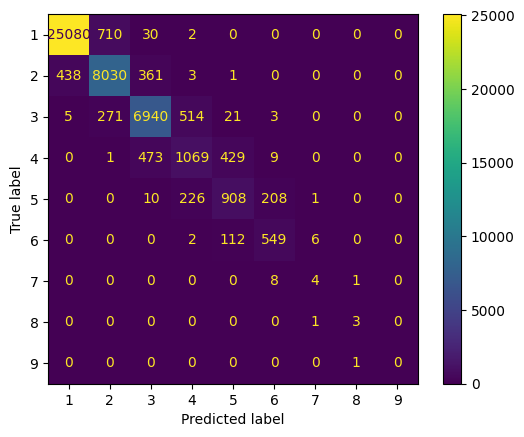

In [53]:
# 5 模型评估
# 5.1 计算准确率
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print('准确率为：', accuracy)
# 5.2 混淆矩阵
# 计算混淆矩阵并保存为图片
# 假设 y_true, y_pred, class_names 已经定义
save_path = PREFIX + 'confusion_matrix_xgb.png'
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
disp.figure_.savefig(save_path)
# 5.3 计算精确率和召回率
precision = precision_score(y_test, y_pred, average='macro')  # 计算宏平均精确率
recall = recall_score(y_test, y_pred, average='macro')  # 计算宏平均召回率

print("精确率为: ", precision)
print("召回率为: ", recall)
# 5.4 计算F1分数
f1 = f1_score(y_test, y_pred, average='macro')  # 计算宏平均F1分数
print("F1分数为: ", f1)
# 计算Cohen's Kappa系数
kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa系数为: ", kappa)

print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))


In [56]:
# 6 模型应用
#  读取待预测数据
result = pd.read_csv(predict_name)
# 预测
y_pred = model.predict(result[columns])
y_pred = xgb_le.inverse_transform(y_pred)
# 保存预测结果至 star_test_lr.csv 文件
result['star_level'] = y_pred
result = result.loc[:, ['uid', 'star_level']]
result.to_csv(PREFIX + 'result.csv', index=False)
